<a href="https://colab.research.google.com/github/Martinmbiro/Imbalanced-Datasets-and-Evaluating-Classification-Models/blob/main/04%20Plot%20ROC%20Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROC Curves**
> A graph that shows how well a classification model performs (usually a binary classification problem, although can be adapted for multi-label classification problems)

+ Plots the True Positive Rate `tpr` (y axis) against the False Positive Rate `fpr` (x axis) at various `threshold` values.

> 💡 **Insight**
+ In the real world, we typically achieve models that perform somewhere between between pure chance (a diagonal line) and perfectly (a line that touches the top left corner)

> ❗ **Recall**  
+ `tpr / sensitivity` - How often `true` labels are correctly identified as `true`
+ `fpr / false alarm rate` - How often `false` labels are incorrectly identified as `true`

## Loading the data
> 📝 **Note**
+ This notebook will be scaled down to a _binary_ classification problem, since `roc` curves are ideally meant for binary classification.
+ This is not to say however, that they cannot be used as evaluation metrics for multi-label classification problems. They can be scaled to fit the same
+ The model trained for this notebook should estimate whether an object detected by lightweight sensors is a `hiker` or a `natural object`

In [ ]:
import pandas as pd

!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/hiker_or_tree.csv

dataset  = pd.read_csv('hiker_or_tree.csv', delimiter='\t')

In [ ]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   height    1000 non-null   float64
 1   is_hiker  1000 non-null   int64  
 2   motion    1000 non-null   float64
 3   texture   1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


In [ ]:
# split dataset into label and features
# features
features = ['height', 'motion', 'texture']
X = dataset[features]

# label
y = dataset['is_hiker']

In [ ]:
# then split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                test_size=0.3, random_state=42)

# X_train info
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 541 to 102
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   height   700 non-null    float64
 1   motion   700 non-null    float64
 2   texture  700 non-null    float64
dtypes: float64(3)
memory usage: 21.9 KB


## Data analysis

### Plotting feature distribution
> A [`histogram`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) will be used to visualize the distribution of the `height`, `motion` and `texture` columns

In [ ]:
# import matplotlilb
import matplotlib.pyplot as plt
# specify style sheet
plt.style.use('fast')

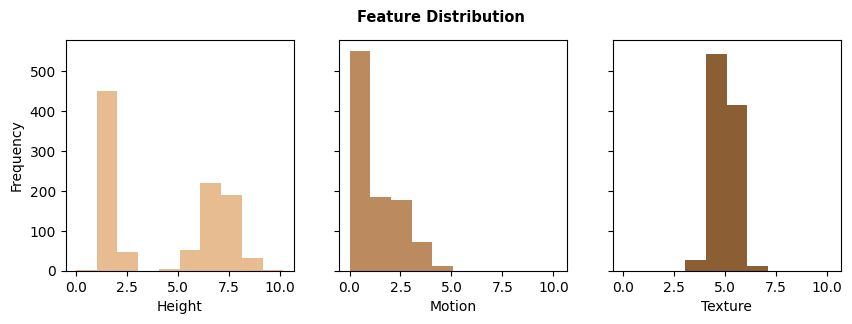

In [ ]:
# colour list
color_list = ['#e7bc91', '#bc8a5f', '#8b5e34']

# define feature and Axes
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# for loop to plot all histograms
for i, feature in enumerate(features):
  dataset.plot.hist(column=feature, xlabel=feature.capitalize(),
                  ax=axs[i], color=color_list[i], legend=False)

# suptitle
plt.suptitle('Feature Distribution', weight='black', fontsize=10.5)
plt.show()

### Relationship between the features and label
> To visualize the relationship between the features `height`, `motion` and `texture` hand the categorical label, `is_hiker`

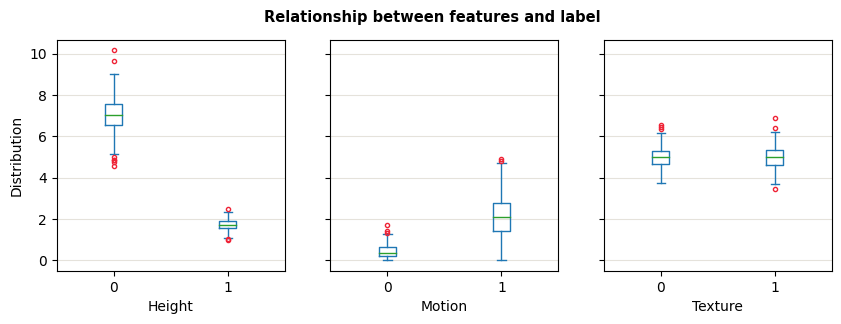

In [ ]:
# specify figure and Axes
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i, feature in enumerate(features):
  dataset.plot.box(column=feature, by='is_hiker', xlabel=feature.capitalize(),
                  flierprops=dict(marker='.', markeredgecolor='#ef2336'),
                  ax = axs[i])

  # blank title
  axs[i].set_title('')
  # grid
  axs[i].grid(axis='y', alpha=0.7, color='#dad7cd')

# subplot y_label:
axs[0].set_ylabel('Distribution')

plt.suptitle('Relationship between features and label', weight='black',
             fontsize=10.5)
plt.show()

> Clearly, there seems to be a relationship between the features and the label, particularly the `height` and `motion` columns.

### Label distribution

In [ ]:
# label class count
dataset['is_hiker'].value_counts().sort_values(ascending=True)

,count
is_hiker,
1,500
0,500


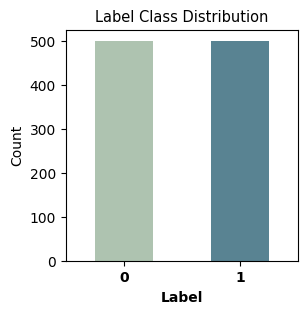

In [ ]:
# visualize in a bar plot
dataset['is_hiker'].value_counts().sort_index(ascending=True).plot.bar(
    figsize=(3, 3),
    color=['#aec3b0', '#598392'],
    rot=0,
    ylabel='Count'
)

plt.title('Label Class Distribution', fontsize=10.5)
plt.xlabel('Label', weight='black')
# get_current_axes and modify xticklabels
plt.gca().set_xticklabels([0, 1], weight='black')
plt.show()


> 💡 **Insight**  
+ This dataset is balanced, hence, there is no need for oversampling

## Feature scaling
> Since there are no categorical features in the dataset, I'll ony be _scaling_ the _numeric_ features.
+ We would have _encoded categorical features_ if they were present in the dataset.
+ A [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) will wrap the numeric column _transformer_ in form of a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
# first, the indices of the numeric features:
numeric_features = [0, 1, 2]

# import necessary classes
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# transformer
num_transform = Pipeline(steps=[
    # (step name, transformer)
    ('impute', SimpleImputer(strategy='median')), # take care of null values
    ('scale', StandardScaler()) # then scale the columns
])

preprocessor = ColumnTransformer(transformers=[
    # (name, transformer, columns)
    ('num', num_transform, numeric_features)
])

## Modelling
> To keep it simple, I'll train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with its default values
+ Hyperparameter tuning will be covered in a later repository and using a more powerful model

In [ ]:
# pipeline with preprocessor + estimator
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

forest_model = Pipeline(steps=[
    #(name, estimator/transformer)
    ('preprocess', preprocessor), # preprocessor
    ('rfc', RandomForestClassifier(n_estimators=1, random_state=42)) #estimator
    #('log', LogisticRegression())
])

In [ ]:
%%time
# train the model
forest_model.fit(X_train, y_train)

# make predictions from the model
y_pred = forest_model.predict(X_test)

CPU times: user 21.8 ms, sys: 1.04 ms, total: 22.9 ms
Wall time: 68.3 ms


## Evaluation
> For evaluation, I'll use [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), [`classification_report_imbalanced`](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.classification_report_imbalanced.html), [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
# import classes
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

### `confusion_matrix`

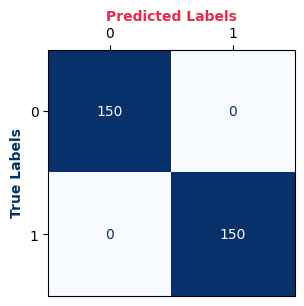

In [ ]:
# specify figure and Axes
fig, ax = plt.subplots(figsize=(3.2, 3.2))

# confusion_matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        colorbar=False,
                                        cmap='Blues',
                                        ax=ax)

# some impression management
ax.set_ylabel('True Labels', weight='black', color='#003262')
ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')

# xlabel & xticks to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

### [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {round(acc, 2)}')

Accuracy score: 1.0


### [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### [`imblearn.metrics.classification_report_imbalanced()`](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.classification_report_imbalanced.html)

In [ ]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00       150
          1       1.00      1.00      1.00      1.00      1.00      1.00       150

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       300



### Visualizing the `roc_curve` using [`RocCurveDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#roccurvedisplay)
> Plotting an `roc_curve` can be a lengthy process, but can be easily done using `scikit-learn's` [`RocCurveDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#roccurvedisplay) class  

> The `RocCurveDisplay` class has 2 _classmethods:_
+ [`from_estimator()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_estimator) - Create an ROC Curve display from an estimator.  
+ [`from_predictions()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions) - Plot an ROC curve from the true and predicted labels

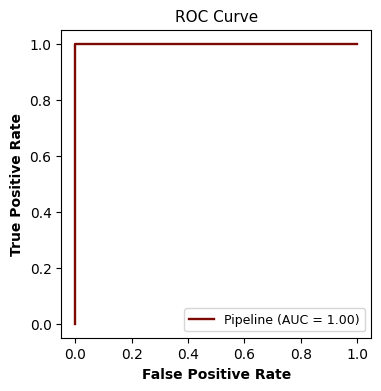

In [ ]:
# specify figure and Axes
fig, ax = plt.subplots(figsize=(4, 4))

# plot the roc_curve
RocCurveDisplay.from_estimator(forest_model, X_test, y_test,
                                 color='#7c0902', linewidth=1.7,
                                 ax=ax)

# some impression management
ax.set_title('ROC Curve', fontsize=11)
ax.set_ylabel('True Positive Rate', weight='black')
ax.set_xlabel('False Positive Rate', weight='black')
ax.legend(fontsize=9)

plt.show()

### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
> The Are Under the Curve (AUC) is a measure of the ability of a _binary classifier_ to distinguish between classes.
+ It is used as a summar of the ROC curve
+ The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes

In [ ]:
# area under curve
auc = roc_auc_score(y_test, y_pred)

print(f'Area Under Curve: {round(auc, 2)}')

Area Under Curve: 1.0


> ✋ **Disclaimer**  
> We seem to have achieved _perfect_ model performance. While that might seem like a good thing, perfect model performance is not always desirable, since a model is meant to _generalize_ well on unseen data.

> That said, several factors could be in play:
+ **Extremely Simple Data** - The dataset might be very simple and linearly separable, making it easy for any model to perfectly classify the data. This could happen if there are clear and distinct boundaries between the classes in the feature space.
>> - This could be the case, especially for the `height` and `motion` features, as seen in how they relate to the target, from the boxplots made earlier in this notebook

> + **Small Dataset** - If the dataset is very small, it might be easy for the models to perfectly fit the data. This would also make it more likely that the models overfit.

> + **Overfitting** - In our case, in the event that the `RandomForestClassifier` is too complex for the dataset, it could perfectly fit the data. Training a simpler model, such as [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) could help.
>> - Though not included in the current notebook, I trained the same data on a simpler model, a `LogisticRegression` model, but achieved the same _perfect_ results

> In the case of an extremely simple dataset, several strategies can be considered to address remedy the issue and achieve more realistic model performance:  
+ If this were a real-world problem and not hypothetical, collecting more data would help increase the size and diversity of the dataset
+ Feature engineering to increase the number of features
+ Introducing controlled noise to make classification harder.
+ Creating synthetic data using oversampling [`methods`](https://imbalanced-learn.org/stable/references/over_sampling.html) such as [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) could add complexity to the data
+ Ensuring rigorous cross-validation practices to verify that the model's performance is robust and not a result of overfitting to a simple dataset

## Tune `roc_curve` decision threshold
> A decision / classification threshold is a _cut-off point that converts predicted probabilities output by a machine learning model into descrete classes_. By default, the threshold is `0.5`  

> Tuning the decision threshold is essential to tailor the model's performance to specific objectives, costs, class imbalances, business metrics, and regulatory requirements. It ensures that the model's predictions align with the real-world needs and constraints of the application.

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np

> [`RandomForestClassifier.predict_proba(X)`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) predicts the _class probabilities_ of an input sample.

In [ ]:
'''
get predicted probabilities, then select all rows of the array,
  but only the second column (probability estimates of the +ve class)
'''
y_probs = forest_model.predict_proba(X_test)[:, 1]

### Youden's J Statistic
> Identify the threshold that maximizes Youden's J statistic (`sensitivity` + `specificity` - `1`)  
+ The [`numpy.argmax(a)`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method returns the indices of the maximum values for an input array-like object, `a`

In [ ]:
# compute roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Youden's J characteristic
j_scores = tpr - fpr
optimal_index = np.argmax(j_scores)
optimal_threshold_j = thresholds[optimal_index]

print(optimal_threshold_j)

1.0


### F1 Score Maximization  
> Find the threshold that maximizes the `F1` score, which is the harmonic mean of `precision` and `recall`

In [ ]:
# compute precision recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)

# F1 score
f1_scores = 2 *((precision*recall)/(precision+recall))
optimal_index_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = pr_thresholds[optimal_index_f1]

print(optimal_threshold_f1)

1.0


### Make predictions using the optimal threshold

In [ ]:
# Make predictions using the optimal threshold from Youden's J characteristic
y_pred_optimal_j = (y_probs >= optimal_threshold_j).astype(int)

In [ ]:
# Find the size
y_pred_optimal_j.size

300

> 📚 **Read on:**  
> + More information on how to tune decision threshold by prioritising specific metrics can be found on the [`scikit-learn`](https://scikit-learn.org/stable/index.html) documentation linked [`here`](https://scikit-learn.org/stable/modules/classification_threshold.html)  
+ Also, [`this`](https://towardsdatascience.com/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58) blog post has valuable insight on the same. Highly recommended.

> Till next time 👋